In [ ]:
%pip install opencv-python

In [ ]:
import json
from pathlib import Path
import cv2

In [ ]:
# categories for layout
categories = {
        0: "Background",
        1: "Text",
        2: "Title",
        3: "List",
        4: "Table",
        5: "Table Caption",
        6: "Figure",
        7: "Figure Caption"
}
coco = {"images": [], "annotations": [], "categories": []}

In [ ]:
# convert dataset to coco format

data_dir = "./dataset/layout/augmented/train"
ann_id = 1
img_id = 1

for json_file in sorted(Path(data_dir).glob("*.json")):
    with open(json_file, "r") as f:
        data = json.load(f)

    file_name = data["file_name"]
    img_path = Path(data_dir) / file_name

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Skipping {file_name}, not found in {data_dir}")
        continue
    
    h, w = img.shape[:2]

    coco["images"].append({
        "id": img_id,
        "file_name": file_name,
        "width": w,
        "height": h
    })

    for anno in data.get("annotations", []):
        x, y, wbox, hbox = anno["bbox"]
        cat_id = int(anno["category_id"])

        coco["annotations"].append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": cat_id,
            "bbox": [x, y, wbox, hbox],
            "area": float(wbox * hbox),
            "iscrowd": 0
        })
        ann_id += 1

    img_id += 1

In [5]:
with open("aug_coco_dataset.json", "w") as f:
    json.dump(coco, f, indent=2)

In [2]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

In [ ]:
train_json = "./aug_coco_dataset.json"   
val_json   = "dataset/val.json"     # after conversion (or split)
img_root   = "./doc-layout/augmented/train"              # folder with images


register_coco_instances("docs_train", {}, train_json, img_root)
MetadataCatalog.get("docs_train").set(thing_classes=categories)
print("✅ Using categories:", categories)


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
))

✅ Using categories: ['Text', 'Title', 'List', 'Table', 'Figure']


In [11]:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("docs_train",)
cfg.DATASETS.TEST  = ()         
cfg.TEST.EVAL_PERIOD = 0  
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 2.5e-4
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categories)

cfg.OUTPUT_DIR = "./output_docs"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [12]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[10/09 18:13:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:07, 23.9MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.bo

[10/09 18:14:03 d2.engine.train_loop]: Starting training from iteration 0


/home/dhrubajit/layoutLM/layout-env/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/09 18:14:07 d2.utils.events]:  eta: 0:24:26  iter: 19  total_loss: 7.196  loss_cls: 1.914  loss_box_reg: 0.6721  loss_rpn_cls: 4.201  loss_rpn_loc: 0.4606    time: 0.1452  last_time: 0.1563  data_time: 0.0061  last_data_time: 0.0019   lr: 4.9953e-06  max_mem: 2163M
[10/09 18:14:09 d2.utils.events]:  eta: 0:24:12  iter: 39  total_loss: 5.244  loss_cls: 1.753  loss_box_reg: 0.7686  loss_rpn_cls: 2.197  loss_rpn_loc: 0.4918    time: 0.1430  last_time: 0.1344  data_time: 0.0021  last_data_time: 0.0020   lr: 9.9902e-06  max_mem: 2163M
[10/09 18:14:12 d2.utils.events]:  eta: 0:24:09  iter: 59  total_loss: 3.168  loss_cls: 1.528  loss_box_reg: 0.7941  loss_rpn_cls: 0.4124  loss_rpn_loc: 0.4547    time: 0.1419  last_time: 0.1250  data_time: 0.0019  last_data_time: 0.0016   lr: 1.4985e-05  max_mem: 2163M
[10/09 18:14:15 d2.utils.events]:  eta: 0:24:11  iter: 79  total_loss: 2.68  loss_cls: 1.276  loss_box_reg: 0.742  loss_rpn_cls: 0.1865  loss_rpn_loc: 0.4384    time: 0.1433  last_time: 0.1

In [3]:
#inference with v1
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog 

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
))

In [5]:
cfg.MODEL.WEIGHTS = "./output_docs/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # threshold for predictions
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5          
cfg.MODEL.DEVICE = "cuda" 

In [6]:
categories = ["Text", "Title", "List", "Table", "Figure"]
MetadataCatalog.get("docs_infer").set(thing_classes=categories)

namespace(name='docs_infer',
          thing_classes=['Text', 'Title', 'List', 'Table', 'Figure'])

In [7]:
predictor = DefaultPredictor(cfg)
cfg.MODEL.ROI_HEADS.NUM_CLASSES


5

In [ ]:
image_path = "./Rotated/ec0d5931-6aee-4805-996f-35d360e72a90.jpg" 
im = cv2.imread(image_path)

In [ ]:
outputs = predictor(im)  

In [ ]:
outputs["instances"].pred_classes.cpu().numpy()
outputs["instances"].pred_classes

tensor([0], device='cuda:0')

In [23]:
instances = outputs["instances"].to("cpu")
boxes = instances.pred_boxes.tensor.numpy()
boxes

array([[ 295.17896,  134.54057, 1147.3995 ,  270.3723 ]], dtype=float32)

In [18]:
classes = instances.pred_classes.numpy()
classes

array([0, 0, 0, 4, 4, 4, 4, 0, 0, 0])

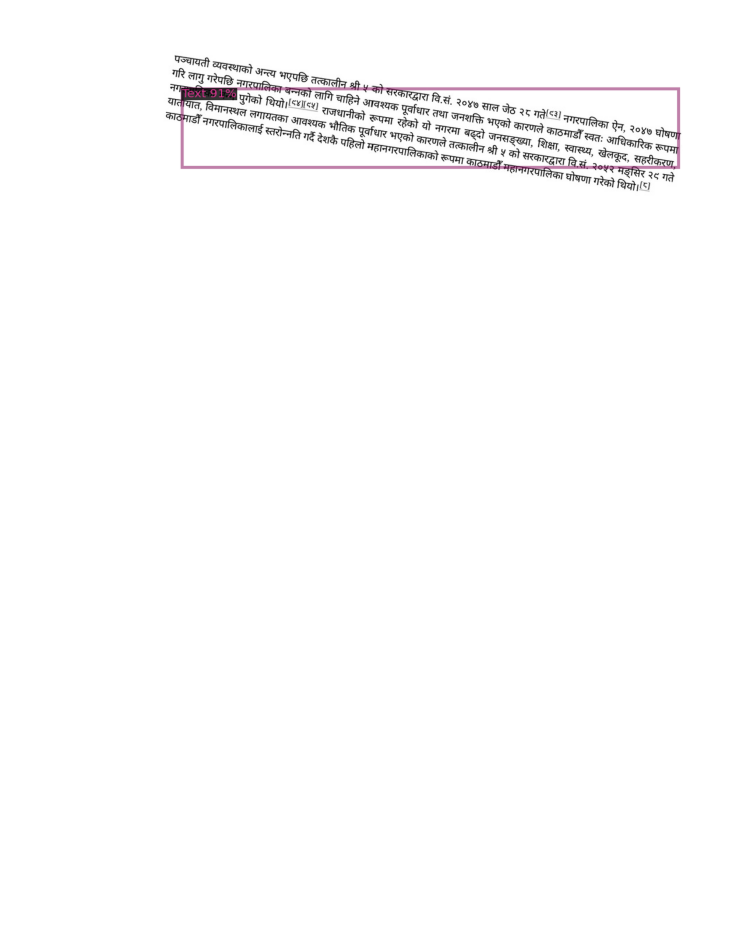

In [24]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("docs_infer"), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(12, 12))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()